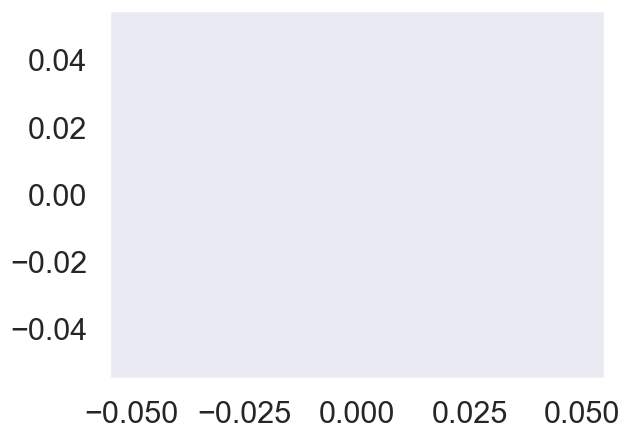

In [10]:
import matplotlib.pyplot as plt
plt.plot();

In [1]:
import matplotlib.pyplot as plt
import gymnasium as gym
from evaluate import evaluate_HIV, evaluate_HIV_population
from train import ProjectAgent  # Replace DummyAgent with your agent implementation
from statistics import mean
from functools import partial
from gymnasium.wrappers import TimeLimit
from env_hiv import HIVPatient
from interface import Agent
import random
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy
import math
import random
import matplotlib
import time
from collections import namedtuple
from itertools import count
from PIL import Image
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
from torch.distributions import Categorical
import ffmpeg
import seaborn as sns
import os

In [183]:
env=TimeLimit(HIVPatient(), max_episode_steps=200)
nb_episodes = 100
states = np.zeros((nb_episodes*200,env.observation_space.shape[0]))
for i in range(nb_episodes):
    s,_ = env.reset()
    for j in range(200):
        s2,r,d,trunc,_ = env.step(env.action_space.sample())
        states[i*200+j] = s2
    print(i, end=', ')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 

KeyboardInterrupt: 

In [201]:
states_means = states[:58*200].mean(axis=0)
states_stds = states[:58*200].std(axis=0)
#save them
np.save('states_means.npy', states_means)
np.save('states_stds.npy', states_stds)
#load them
states_means = np.load('states_means.npy')
states_stds = np.load('states_stds.npy')

In [203]:
print(states_means, states_stds)

[2.91094576e+05 9.01497972e+03 1.36577217e+02 3.84565741e+01
 4.24722752e+04 5.99797527e+01] [1.03830926e+05 1.51257497e+04 1.87096979e+02 2.16227752e+01
 7.32908304e+04 2.94336453e+01]


In [179]:
print(states_means, states_stds)

[1.63573e+05 1.19450e+04 5.00000e+00 4.60000e+01 6.39190e+04 2.40000e+01] [0. 0. 0. 0. 0. 0.]


In [2]:
class ReplayBuffer:
    def __init__(self, capacity, device):
        self.capacity = int(capacity) # capacity of the buffer
        self.data = []
        self.index = 0 # index of the next cell to be filled
        self.device = device
    def append(self, s, a, r, s_, d):
        if len(self.data) < self.capacity:
            self.data.append(None)
        self.data[self.index] = (s, a, r, s_, d)
        self.index = (self.index + 1) % self.capacity
    def sample(self, batch_size):
        batch = random.sample(self.data, batch_size)
        return list(map(lambda x:torch.Tensor(np.array(x)).to(self.device), list(zip(*batch))))
    def __len__(self):
        return len(self.data)

In [3]:
def greedy_action(network, state):
    device = "cuda" if next(network.parameters()).is_cuda else "cpu"
    with torch.no_grad():
        Q = network(torch.Tensor(state).unsqueeze(0).to(device))
        return torch.argmax(Q).item()

In [6]:
def evaluate_agent(agent: Agent, env: gym.Env, nb_episode: int = 10, scaling='log') -> float:
    """
    Evaluate an agent in a given environment.

    Args:
        agent (Agent): The agent to evaluate.
        env (gym.Env): The environment to evaluate the agent in.
        nb_episode (int): The number of episode to evaluate the agent.

    Returns:
        float: The mean reward of the agent over the episodes.
    """
    states_means = np.load('states_means.npy')
    states_stds = np.load('states_stds.npy')
    rewards: list[float] = []
    for _ in range(nb_episode):
        obs, info = env.reset()
        if scaling == 'log':
            obs = np.log10(obs + 1)
        elif scaling == 'standard':
            obs = (obs - states_means) / states_stds
        done = False
        truncated = False
        episode_reward = 0
        while not done and not truncated:
            action = agent.act(obs)
            obs, reward, done, truncated, _ = env.step(action)
            if scaling == 'log':
                obs = np.log10(obs + 1)
            elif scaling == 'standard':
                obs = (obs - states_means) / states_stds
            episode_reward += reward
        rewards.append(episode_reward)
    env.reset()
    return mean(rewards)

# DQN

In [35]:
class dqn_agent:
    def __init__(self, config, model, load=False):
        device = "cuda" if next(model.parameters()).is_cuda else "cpu"
        self.gamma = config['gamma']
        self.batch_size = config['batch_size']
        self.nb_actions = config['nb_actions']
        self.memory = ReplayBuffer(config['buffer_size'], device)
        self.epsilon_max = config['epsilon_max']
        self.epsilon_min = config['epsilon_min']
        self.epsilon_stop = config['epsilon_decay_period']
        self.epsilon_delay = config['epsilon_delay_decay']
        self.epsilon_step = (self.epsilon_max - self.epsilon_min) / self.epsilon_stop
        self.model = model
        self.criterion = torch.nn.SmoothL1Loss() #Or torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config['learning_rate'])
        self.device = device  # Store device
        self.load = load
        self.losses = []
        self.best_model_path = config['model_path']  # File name for saving the best model
        if config['scaling']=='standard':
            self.states_means = np.load('states_means.npy')
            self.states_stds =np.load('states_stds.npy')
            self.scaling = 'standard'
        elif config['scaling']=='log':
            self.scaling = 'log'


    def gradient_step(self):
        if len(self.memory) > self.batch_size:
            X, A, R, Y, D = self.memory.sample(self.batch_size)
            QYmax = self.model(Y).max(1)[0].detach()
            update = torch.addcmul(R, 1 - D, QYmax, value=self.gamma)
            QXA = self.model(X).gather(1, A.to(torch.long).unsqueeze(1))
            loss = self.criterion(QXA, update.unsqueeze(1))
            self.losses.append(loss.item())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def train(self, env, max_episode):
        episode_return = []
        episode = 0
        episode_cum_reward = 0
        state, _ = env.reset()
        if self.scaling == 'log':
            state = np.log10(state + 1)
        elif self.scaling == 'standard':
            state = (state - self.states_means) / self.states_stds
        epsilon = self.epsilon_max
        step = 0

        # Track the best reward
        best_deterministic_reward = -float('inf')
        if self.load:
            best_deterministic_reward = evaluate_agent(self, env, 1, scaling=self.scaling)/1_000_000
            print(f"Loaded model with deterministic reward {best_deterministic_reward:.2f}M")
        while episode < max_episode:
            # update epsilon
            if step > self.epsilon_delay:
                epsilon = max(self.epsilon_min, epsilon - self.epsilon_step)

            # select epsilon-greedy action
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = greedy_action(self.model, state)

            # step
            next_state, reward, done, trunc, _ = env.step(action)
            true_reward = reward/1_000_000
            reward = np.log10(reward + 100_000)
            if self.scaling == 'log':
                next_state = np.log10(next_state + 1)
            elif self.scaling == 'standard':
                next_state = (next_state - self.states_means) / self.states_stds
            self.memory.append(state, action, reward, next_state, done)
            episode_cum_reward += true_reward

            # train
            self.gradient_step()

            # next transition
            step += 1
            if done or trunc:
                episode += 1
                print("Episode {:3d}".format(episode), 
                      "epsilon {:6.2f}".format(epsilon), 
                      "batch size {:5d}".format(len(self.memory)), 
                      "episode return {:4.1f}M".format(episode_cum_reward),
                        "loss {:4.1f}".format(self.losses[-1]),
                      sep=', ')
                state, _ = env.reset()
                if self.scaling == 'log':
                    state = np.log10(state + 1)
                elif self.scaling == 'standard':
                    state = (state - self.states_means) / self.states_stds
                episode_return.append(episode_cum_reward)
                # Check if current episode return is better than the best
                deterministic_reward = evaluate_agent(self, env, 1, scaling=self.scaling)/1_000_000
                # Save the best model
                if deterministic_reward > best_deterministic_reward:
                    best_deterministic_reward = deterministic_reward
                    torch.save(self.model.state_dict(), self.best_model_path)
                    torch.save(best_deterministic_reward, "best_deterministic_reward.pth")
                    print("Evaluation deterministic reward", f"{deterministic_reward:.1f}M")
                episode_cum_reward = 0
            else:
                state = next_state

        return episode_return

    def act(self, state):
        return greedy_action(self.model, state)

In [33]:
env = TimeLimit(HIVPatient(), max_episode_steps=200)

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Declare network
state_dim = env.observation_space.shape[0]
n_action = env.action_space.n 
nb_neurons=128
DQN = torch.nn.Sequential(nn.Linear(state_dim, nb_neurons),
                          nn.ReLU(),
                          nn.Linear(nb_neurons, nb_neurons),
                          nn.ReLU(), 
                          nn.Linear(nb_neurons, n_action)).to(device)

# DQN config
config = {'nb_actions': n_action,
          'learning_rate': 0.01,
          'gamma': 0.95,
          'buffer_size': 100_000,
          'epsilon_min': 0.01,
          'epsilon_max': 1.,
          'epsilon_decay_period': 5_000,
          'epsilon_delay_decay': 600,
          'batch_size': 32,
          'model_path': 'best_model_standard_scaling.pth',
          'scaling': 'standard'}

# Train agent
agent = dqn_agent(config, DQN)
scores = agent.train(env, 300)
#plt.plot(scores)

Episode   1, epsilon   1.00, batch size   200, episode return 10.3M, loss 39189.9
Evaluation deterministic reward 6.8M
Episode   2, epsilon   1.00, batch size   400, episode return 11.0M, loss 430363.0
Episode   3, epsilon   1.00, batch size   600, episode return  9.2M, loss 1643426.2
Episode   4, epsilon   0.96, batch size   800, episode return 10.4M, loss 3523872.8
Episode   5, epsilon   0.92, batch size  1000, episode return  9.1M, loss 4551970.0
Episode   6, epsilon   0.88, batch size  1200, episode return  8.8M, loss 5777839.0
Episode   7, epsilon   0.84, batch size  1400, episode return  8.9M, loss 3334394.5
Episode   8, epsilon   0.80, batch size  1600, episode return  7.7M, loss 2015005.1
Episode   9, epsilon   0.76, batch size  1800, episode return 14.4M, loss 1441623.5
Episode  10, epsilon   0.72, batch size  2000, episode return 16.5M, loss 1683770.2
Episode  11, epsilon   0.68, batch size  2200, episode return  8.9M, loss 819838.5
Episode  12, epsilon   0.64, batch size  24

In [ ]:
env = TimeLimit(HIVPatient(), max_episode_steps=200)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Declare network
state_dim = env.observation_space.shape[0]
n_action = env.action_space.n 
nb_neurons=32
config = {'nb_actions': n_action,
          'learning_rate': 0.01,
          'gamma': 0.99,
          'buffer_size': 100_000,
          'epsilon_min': 0.05,
          'epsilon_max': 1.,
          'epsilon_decay_period': 1000,
          'epsilon_delay_decay': 20,
          'batch_size': 32,
          'model_path': 'best_model.pth'}

##Train and load the best model
DQN = torch.nn.Sequential(nn.Linear(state_dim, nb_neurons),
                          nn.ReLU(),
                          nn.Linear(nb_neurons, nb_neurons),
                          nn.ReLU(), 
                          nn.Linear(nb_neurons, n_action)).to(device)


#load the best model
DQN.load_state_dict(torch.load("best_model.pth", weights_only=True))
agent = dqn_agent(config, DQN, load=True)
scores = agent.train(env, 100)

Loaded model with deterministic reward 416.88M
Episode   1, epsilon   0.83, batch size   200, episode return  8.5
Episode   2, epsilon   0.64, batch size   400, episode return 12.7
Episode   3, epsilon   0.45, batch size   600, episode return 12.4
Episode   4, epsilon   0.26, batch size   800, episode return 51.8
Episode   5, epsilon   0.07, batch size  1000, episode return 39.8
Episode   6, epsilon   0.05, batch size  1200, episode return 12.2
Episode   7, epsilon   0.05, batch size  1400, episode return 17.9
Episode   8, epsilon   0.05, batch size  1600, episode return 21.1
Episode   9, epsilon   0.05, batch size  1800, episode return 19.1
Episode  10, epsilon   0.05, batch size  2000, episode return  9.4
Episode  11, epsilon   0.05, batch size  2200, episode return 27.4
Episode  12, epsilon   0.05, batch size  2400, episode return 67.6
Episode  13, epsilon   0.05, batch size  2600, episode return 21.6
Episode  14, epsilon   0.05, batch size  2800, episode return 25.2
Episode  15, ep

# Evaluate Agent

In [37]:
evaluate_agent(agent=agent, env=env, nb_episode=1)

np.float64(3652153.312549549)

In [40]:
state_dim = env.observation_space.shape[0]
n_action = env.action_space.n 
nb_neurons=128
DQN = torch.nn.Sequential(nn.Linear(state_dim, nb_neurons),
                          nn.ReLU(),
                          nn.Linear(nb_neurons, nb_neurons),
                          nn.ReLU(), 
                          nn.Linear(nb_neurons, n_action)).to(device)
#load best model
DQN.load_state_dict(torch.load("best_model_standard_scaling.pth", weights_only=False))
agent = dqn_agent(config, DQN)
result = evaluate_agent(agent=agent, env=env, nb_episode=1, scaling='standard') / 1_000_000
print(f"Evaluation result: {result:.2f}M")

Evaluation result: 5753.70M


# ActorCritic

In [90]:
# Direct variable assignments instead of argument parsing
class Args:
     device = 0  # cuda device
     verbose = 1  # printing preferences
     load = False  # if loading an existing model
     save = True  # if saving an existing model
     plot = True  # if plotting an existing model
     model = 'reinforce_hiv/model.pt'  # model path
     runtype = 'train_run'  # runtype: train only or train and validate
     lr = 0.001  # learning rate
     episodes = 1000  # number of episodes
     gamma = 0.99  # discount factor

args = Args()

# Setup environment
env = TimeLimit(HIVPatient(), max_episode_steps=200)
normalize_cnsts = np.array([1.63573e+05, 1.19450e+04, 5.00000e+00, 4.60000e+01, 6.39190e+04, 2.40000e+01])
#env = gym.make('CartPole-v1')

# Set the cuda visible devices
os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(args.device)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Actor network
class Actor(nn.Module): 
     def __init__(self, in_size, out_size): 
          super(Actor, self).__init__()
          self.linear1 = nn.Linear(in_size, 128)
          self.linear2 = nn.Linear(128, 128)
          self.linear3 = nn.Linear(128, out_size)
          #self.dropout = nn.Dropout(0.7)
          self.softmax = nn.Softmax(dim=1)

          self.policy_history = Variable(torch.Tensor()).to(device)
          self.reward_episode = []

          self.reward_history = []
          self.loss_history = []
  
     def forward(self, x): 
          # Convert numpy state to tensor
          x = Variable(torch.from_numpy(x).float().unsqueeze(0)).to(device)
          x = F.relu(self.linear1(x))
          x = F.relu(self.linear2(x))
          #x = self.dropout(x)
          x = self.softmax(self.linear3(x))
          return x

# Critic network
class Critic(nn.Module): 
     def __init__(self, in_size): 
          super(Critic, self).__init__()
          self.linear1 = nn.Linear(in_size, 128)
          self.linear2 = nn.Linear(128, 128)
          self.linear3 = nn.Linear(128, 1)
          #self.dropout = nn.Dropout(0.7)

          self.value_episode = []
          self.value_history = Variable(torch.Tensor()).to(device)
     
     def forward(self, x): 
          x = Variable(torch.from_numpy(x).float().unsqueeze(0)).to(device)
          x = F.relu(self.linear1(x))
          x = F.relu(self.linear2(x))
          x = F.relu(self.linear3(x))
          return x 

# Combined module (mostly for loading / storing)
class ActorCritic(nn.Module): 
     def __init__(self, actor, critic): 
          super(ActorCritic, self).__init__()
          self.actor = actor
          self.critic = critic
  
     def forward(self, x):
          value = self.critic(x)
          policy = self.actor(x)
          return value, policy

class Runner(): 
     def __init__(self, actor, critic, a_optimizer, c_optimizer, gamma=0.99, logs="hiv"):
          self.actor = actor
          self.critic = critic
          self.a_opt = a_optimizer
          self.c_opt = c_optimizer
          self.gamma = gamma
          self.logs = logs
          self.writer = SummaryWriter(logs)
          self.entropy = 0
          self.plots = {"Actor Loss": [], "Critic Loss": [], "Reward": [], "Mean Reward": []}

     def env_step(self, action):
          state, reward, done, trunc, log = env.step(action)
          return torch.FloatTensor([state]).to(device), torch.FloatTensor([reward]).to(device), done, trunc, log

     def select_action(self, state):
          # Convert state to tensor
          probs = self.actor(state)
          c = Categorical(probs)
          action = c.sample()

          # Place log probabilities into the policy history log\pi(a | s)
          if self.actor.policy_history.dim() != 0: 
                self.actor.policy_history = torch.cat([self.actor.policy_history, c.log_prob(action)])
          else: 
                self.actor.policy_history = (c.log_prob(action))
     
          return action
  
     def estimate_value(self, state): 
          pred = self.critic(state).squeeze(0)
          if self.critic.value_history.dim() != 0: 
                self.critic.value_history = torch.cat([self.critic.value_history, pred])
          else: 
                self.critic.policy_history = (pred)

     def update_a2c(self):
          R = 0
          q_vals = []

          # "Unroll" the rewards, apply gamma
          for r in self.actor.reward_episode[::-1]: 
                R = r + self.gamma * R
                q_vals.insert(0, R)
     
          q_vals = torch.FloatTensor(q_vals).to(device)
          values = self.critic.value_history
          log_probs = self.actor.policy_history
     
          advantage = q_vals - values
  
          self.c_opt.zero_grad()
          critic_loss = 0.0005 * advantage.pow(2).mean()
          critic_loss.backward()
          self.c_opt.step()

          self.a_opt.zero_grad()
          actor_loss = (-log_probs * advantage.detach()).mean() + 0.001 * self.entropy
          actor_loss.backward()
          self.a_opt.step()

          self.actor.reward_episode = []
          self.actor.policy_history = Variable(torch.Tensor()).to(device)
          self.critic.value_history = Variable(torch.Tensor()).to(device)
     
          return actor_loss, critic_loss
  
     def train(self, episodes=200, smooth=10):
          smoothed_reward = []
     
          for episode in range(episodes): 
                rewards = 0
                state = np.log10(env.reset()[0]+1)
                self.entropy = 0
                done = False

                for step in range(500): 
                     self.estimate_value(state)
          
                     policy = self.actor(state).cpu().detach().numpy()
                     action = self.select_action(state)
                     e = -np.sum(np.mean(policy) * np.log(policy))
                     self.entropy += e

                     state, reward, done, trunc, _ = env.step(action.data[0].item())
                     state = np.log10(state+1)
                     reward/= 1_000_000
                     rewards += reward

                     self.actor.reward_episode.append(reward)

                     if done or trunc:
                          break
        
                smoothed_reward.append(rewards)
                if len(smoothed_reward) > smooth: 
                     smoothed_reward = smoothed_reward[-1*smooth: -1]

                a_loss, c_loss = self.update_a2c()
        
                self.writer.add_scalar("Critic Loss", c_loss, episode)
                self.writer.add_scalar("Actor Loss", a_loss, episode)
                self.writer.add_scalar("Reward", rewards, episode)
                self.writer.add_scalar("Mean Reward", np.mean(smoothed_reward), episode)

                self.plots["Critic Loss"].append(c_loss.item() * 100)
                self.plots["Actor Loss"].append(a_loss.item())
                self.plots["Reward"].append(rewards)
                self.plots["Mean Reward"].append(np.mean(smoothed_reward))

                if episode % 5 == 0: 
                     print("Actor Loss: ", a_loss.item(), "Critic Loss: ", c_loss.item())
                     print("\tEpisode {} \t Final Reward {:.2f} \t Average Reward: {:.2f}".format(episode, rewards, np.mean(smoothed_reward)))

     def run(self):
          sns.set_style("dark")
          sns.set_context("poster")
          rewards = 0
          state = np.log10(env.reset()[0])
          for time in range(500):
                action = self.select_action(state) 
                state, reward, done, trunc, _ = env.step(action.data[0].item())
                state = np.log10(state)
                rewards += reward
                if done or trunc:
                     break

          print("\tTotal Reward: ", rewards)
          env.close()
          print("\tSaving Animation ...")
     
     def save(self): 
          ac = ActorCritic(self.actor, self.critic)
          torch.save(ac.state_dict(), '%s/model.pt' % self.logs)

     def plot(self):
          sns.set()
          sns.set_context("poster")

          plt.figure(figsize=(20, 16))
          plt.plot(np.arange(len(self.plots["Actor Loss"])), self.plots["Actor Loss"], label="Actor")
          plt.plot(np.arange(len(self.plots["Critic Loss"])), self.plots["Critic Loss"], label="Critic (x100)")
          plt.legend()
          plt.title("A2C Loss")
          plt.xlabel("Episodes")
          plt.ylabel("Loss")
          plt.savefig("%s/plot_%s.png" % (self.logs, "loss"))

          plt.figure(figsize=(20, 16))
          plt.plot(np.arange(len(self.plots["Reward"])), self.plots["Reward"], label="Reward")
          plt.plot(np.arange(len(self.plots["Mean Reward"])), self.plots["Mean Reward"], label="Mean Reward")
          plt.legend()
          plt.title("A2C Rewards")
          plt.xlabel("Episodes")
          plt.ylabel("Rewards")
          plt.savefig("%s/plot_%s.png" % (self.logs, "rewards"))


In [97]:
env = TimeLimit(HIVPatient(), max_episode_steps=200)
actor = Actor(env.observation_space.shape[0], env.action_space.n).to(device)
print(env.reset()[0].shape, env.reset()[0])
action = actor(np.log10(env.reset()[0]))
print(action[0].shape, action[0])

(6,) [1.63573e+05 1.19450e+04 5.00000e+00 4.60000e+01 6.39190e+04 2.40000e+01]
torch.Size([4]) tensor([0.0904, 0.8784, 0.0192, 0.0120], device='cuda:0',
       grad_fn=<SelectBackward0>)


[Device]	Device selected:  cuda: 0
[Train]	Training Beginning ...
Actor Loss:  43.27046585083008 Critic Loss:  0.8602427840232849
	Episode 0 	 Final Reward 127.43 	 Average Reward: 127.43
Actor Loss:  238.7796630859375 Critic Loss:  119.47193908691406
	Episode 5 	 Final Reward 1150.19 	 Average Reward: 273.05
Actor Loss:  23.798105239868164 Critic Loss:  0.9707042574882507
	Episode 10 	 Final Reward 162.14 	 Average Reward: 232.84
Actor Loss:  29.433923721313477 Critic Loss:  2.9700520038604736
	Episode 15 	 Final Reward 244.10 	 Average Reward: 260.85
Actor Loss:  43.39370346069336 Critic Loss:  6.610876083374023
	Episode 20 	 Final Reward 409.12 	 Average Reward: 182.04
Actor Loss:  -3.661275625228882 Critic Loss:  0.23881511390209198
	Episode 25 	 Final Reward 130.78 	 Average Reward: 183.80
Actor Loss:  -8.452539443969727 Critic Loss:  0.6102503538131714
	Episode 30 	 Final Reward 122.27 	 Average Reward: 203.44
Actor Loss:  0.6057744026184082 Critic Loss:  0.6415588855743408
	Epis

C:\Users\habib\AppData\Local\Temp\ipykernel_26764\4255586376.py:167: RuntimeWarning: divide by zero encountered in log
  e = -np.sum(np.mean(policy) * np.log(policy))


Actor Loss:  inf Critic Loss:  7.240115165710449
	Episode 375 	 Final Reward 591.82 	 Average Reward: 299.91
Actor Loss:  0.7301380634307861 Critic Loss:  2.621168613433838
	Episode 380 	 Final Reward 392.92 	 Average Reward: 416.93
Actor Loss:  -3.313068151473999 Critic Loss:  4.075839996337891
	Episode 385 	 Final Reward 214.89 	 Average Reward: 370.30
Actor Loss:  -2.549090623855591 Critic Loss:  2.158564805984497
	Episode 390 	 Final Reward 156.89 	 Average Reward: 381.54
Actor Loss:  1.4010388851165771 Critic Loss:  0.47473007440567017
	Episode 395 	 Final Reward 122.56 	 Average Reward: 285.14
Actor Loss:  2.8159351348876953 Critic Loss:  0.18808241188526154
	Episode 400 	 Final Reward 96.21 	 Average Reward: 152.18
Actor Loss:  3.5786654949188232 Critic Loss:  0.06920451670885086
	Episode 405 	 Final Reward 100.31 	 Average Reward: 123.95
Actor Loss:  3.8773624897003174 Critic Loss:  0.07178296148777008
	Episode 410 	 Final Reward 87.24 	 Average Reward: 114.55
Actor Loss:  4.19

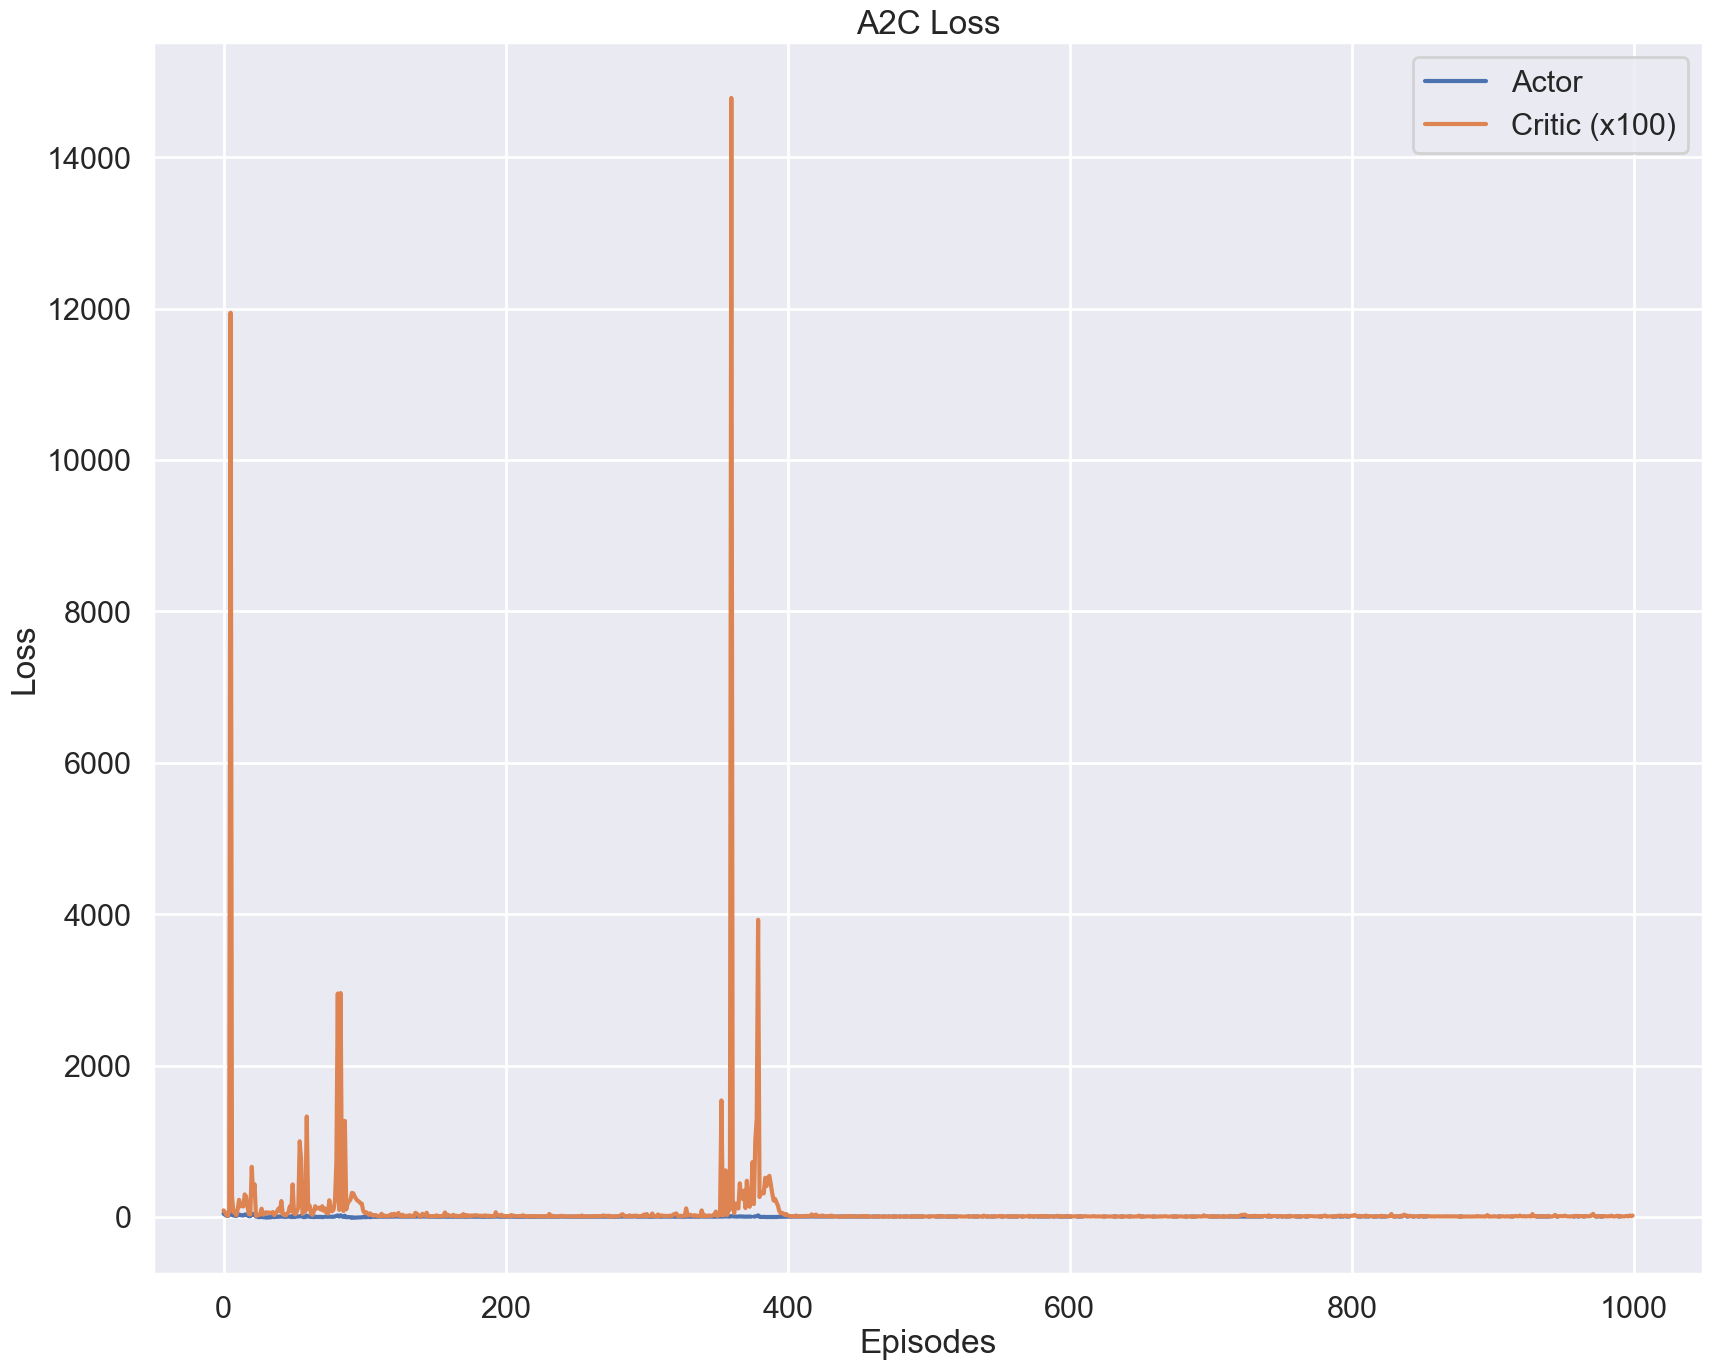

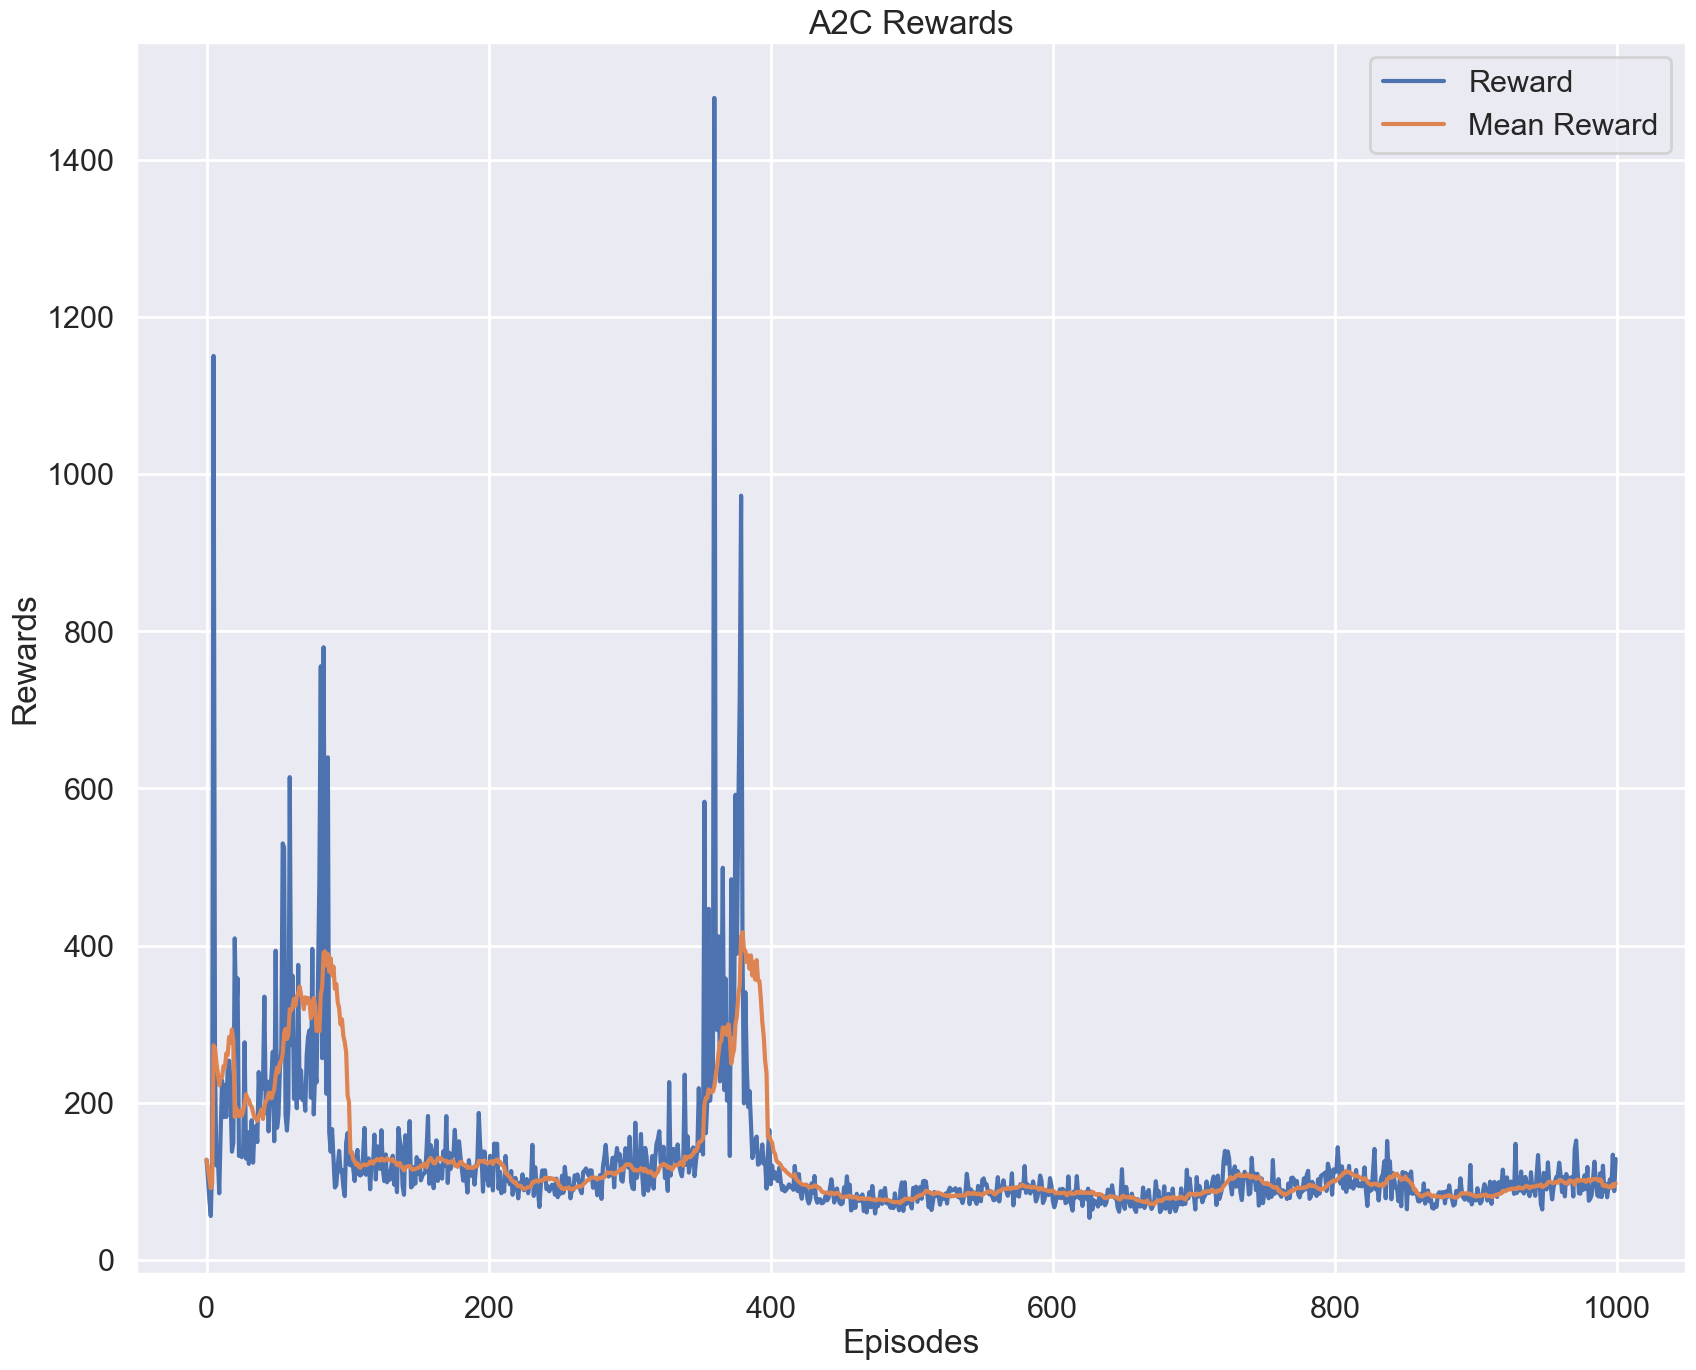

<Figure size 640x480 with 0 Axes>

In [91]:
device_name = "cuda: %s" % (args.device) if torch.cuda.is_available() else "cpu"
print("[Device]\tDevice selected: ", device_name)

actor = Actor(env.observation_space.shape[0], env.action_space.n).to(device)
critic = Critic(env.observation_space.shape[0]).to(device)
ac = ActorCritic(actor, critic)

# If we're loading a model
if args.load: 
     ac.load_state_dict(torch.load(args.model))
     actor = ac.actor
     critic = ac.critic

a_optimizer = optim.Adam(actor.parameters(), lr=args.lr)
c_optimizer = optim.Adam(critic.parameters(), lr=args.lr)

runner = Runner(actor, critic, a_optimizer, c_optimizer, logs="a2c_cartpole/%s" % time.time())

if "train" in args.runtype:
     print("[Train]\tTraining Beginning ...")
     runner.train(args.episodes)

     if args.plot:
               print("[Plot]\tPlotting Training Curves ...")
               runner.plot()

if args.save: 
     print("[Save]\tSaving Model ...")
     runner.save()

if "run" in args.runtype:
     print("[Run]\tRunning Simulation ...")
     runner.run()

print("[End]\tDone. Congratulations!")

In [95]:
def evaluate_actor(agent: Actor, env: gym.Env, nb_episode: int = 10) -> float:
    """
    Evaluate an actor agent in a given environment.

    Args:
        agent (Actor): The actor agent to evaluate.
        env (gym.Env): The environment to evaluate the agent in.
        nb_episode (int): The number of episodes to evaluate the agent.

    Returns:
        float: The mean reward of the agent over the episodes.
    """
    rewards: list[float] = []
    for _ in range(nb_episode):
        obs, info = env.reset()
        done = False
        truncated = False
        episode_reward = 0
        while not done and not truncated:
            action = agent(obs)
            action = torch.argmax(action).item()
            obs, reward, done, truncated, _ = env.step(action)
            episode_reward += reward
        rewards.append(episode_reward)
    return mean(rewards)

In [96]:
evaluate_HIV = partial(evaluate_actor, env=env)
score_agent: float = evaluate_HIV(agent=actor, nb_episode=1)
score_agent

np.float64(5426976.930085338)

Tester de 
- prendre en compte les actions précédentes/states précédents pour prédire la prochaine action
- 